# Predicting text for a Harry Potter book

> We will try to predict text in context to a Harry Potter novel.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [nlp, tensorflow]

In this blog post, we will try to predict text in context to a Harry Potter novel.

In text prediction, we can get a body of texts, extract the vocabulary from it, and then create datasets from that, where we make it phrase the Xs, and the next word in that phrase will be the Ys.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import tensorflow as tf
import numpy as np 

Our sample text is from the Harry Potter books. We'll create a Python list of sentences from the data and convert all of that to lowercase.    

Using the `tokenizer`, we'll call `fit_on_texts` to this corpus of work and it will create the dictionary of words and the overall corpus. This is a key-value pair, with the key being the word, and the value being the token for that word.

In [ ]:
data = open('/content/potter.txt').read()

In [ ]:
corpus = data.lower().split("\n")

In [ ]:
#collapse-output
corpus[:10]

["mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much. they were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. ",
 'mr. dursley was the director of a firm called grunnings, which made drills. he was a big, beefy man with hardly any neck, although he did have a very large mustache. mrs. dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. the dursleys had a small son called dudley and in their opinion there was no finer boy anywhere. ',
 "the dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. they didn't think they could bear it if anyone found out about the potters. mrs. potter was mrs. dursley's sister, but they hadn't met for s

We then find the total number of words in the corpus by getting the length of its `word_index`. We add `1` to this to consider out-of-vocabulary variables.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

Let's take this corpus and turn it into training data.  
Our training Xs will be a Python list called `input_sequences`. Then for each line in the corpus, we'll generate a token list using the tokenizer's `texts_to_sequences` method. This will convert a line of text into a list of the tokens representing the words.  
Then we'll iterate over this list of tokens and create a number of `n_gram_sequence`.

In [ ]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

Next, we need to find the length of the longest sentence in the corpus. Then we pad all of the sequences so that they are of the same length. We'll use `padding = pre` so as to make it easier to extract the label.

In [ ]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Now we turn the sequences into our Xs (input values) and Ys (labels). All we do is take all except the last character as our X, and the last character as our Y.

In [ ]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

Now we'll one-hot-encode our labels as this is really a classification problem, where given a sequence of qords, we can classify from the corpus what the next word would likely be. We use the keras utility function to convert a list into a categorical

In [ ]:
label = ku.to_categorical(label, num_classes=total_words)

Now we'll create a neural network to train it with the data. It's a `Sequential` model with an `Embedding` with 128 dimensions to handle al of our words. Another parameter i.e. the `input_length` is equal to the length of the longest sentence minus 1 since we cropped off the last word of each sequence to get the label. It also has an `Bidirectional` `LSTM` with 150 units. The cell state of the LSTM will carry context along with them. The model also consists of a `Dropout` and a couple of `Dense` layers. The output layer is activated by `softmax`. Since we're doing a categorical classification, we'll set the loss to be `categorical_crossentropy`. We'll use the `adam` optimizer.

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 201, 128)          772224    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 201, 300)          334800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 201, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 6033)              609333    
_________________________________________________________________
dense_4 (Dense)              (None, 6033)              36403122  
_________________________________________________________________
dense_5 (Dense)              (None, 6033)             

We will create a `callback` to stop the training when the model accuracy reaches 85%.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.15):
      print("\nReached 85% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(predictors, label, epochs=30, verbose=1, callbacks=[callbacks])

Epoch 1/30
2339/2339 [==============================] - 214s 92ms/step - loss: 4.7067 - accuracy: 0.1652
Epoch 2/30
2339/2339 [==============================] - 214s 91ms/step - loss: 4.6510 - accuracy: 0.1694
Epoch 3/30
2339/2339 [==============================] - 214s 91ms/step - loss: 4.6034 - accuracy: 0.1739
Epoch 4/30
2339/2339 [==============================] - 214s 91ms/step - loss: 4.5633 - accuracy: 0.1779
Epoch 5/30
2339/2339 [==============================] - 214s 91ms/step - loss: 4.5193 - accuracy: 0.1829
Epoch 6/30
2339/2339 [==============================] - 214s 91ms/step - loss: 4.4793 - accuracy: 0.1864
Epoch 7/30
2339/2339 [==============================] - 215s 92ms/step - loss: 4.4420 - accuracy: 0.1910
Epoch 8/30
2339/2339 [==============================] - 215s 92ms/step - loss: 4.4085 - accuracy: 0.1937
Epoch 9/30
2339/2339 [==============================] - 214s 91ms/step - loss: 4.3689 - accuracy: 0.1977
Epoch 10/30
2339/2339 [==============================] 

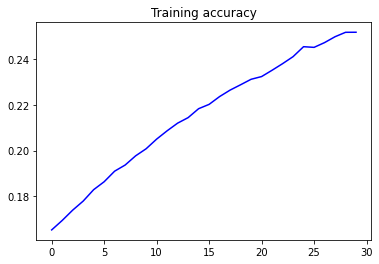

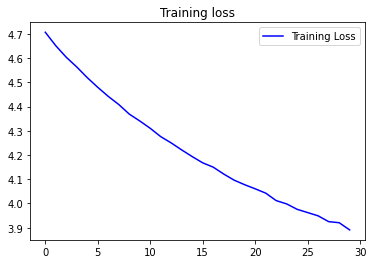

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

Now for the fun part! Let's try predicting words using this model that we trained on. We'll seed it with a text and ask the model for the next 6 words.  
What the model is doing is that for each of the next 6 words, it's going to create token lists using tokenizer text sequences of the `seed_text`. 

In [ ]:
seed_text = "Harry was trying out a new spell when"
next_words = 6
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Harry was trying out a new spell when he looked into the other room


What we see here is that the sentence predicted does make sense gramatically. But because our dataset is comparatively small and each prediction is a probability, the quality of the prediction is bound to get worse further down the line.

---